# Predicting Customer Churn using a Machine Learning approach


## Data: Telecom company subscribers sample | Algorithm: Extreme Gradient Boosting

***

## Introduction

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes how to use machine learning (ML) for the automated identification of unhappy customers, also known as **customer churn prediction**. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the **relative costs** of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us – **leaving a mobile phone operator**. If the provider knows that some of their customers are thinking of leaving, it can offer timely incentives to stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

## Environment and Data

First, we will import the Python libraries needed for the remainder of the exercise. Afterwards we can load the text file containing the data set *"Churn.txt"* in our Python environmnent.

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes – after all, predicting the future is tricky business! But we can also deal with prediction errors from a business cost point of view.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets (UCI ML Repository).

In [245]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

pd.set_option('display.float_format', lambda x: '%8.2f' % x)


# Reading the data with pd.read_csv function

tot = pd.read_csv('churn.txt')
tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 546.9+ KB


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

* State: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
* Account Length: the number of days that this account has been active
* Area Code: the three-digit area code of the corresponding customer’s phone number
* Phone: the remaining seven-digit phone number
* Int’l Plan: whether the customer has an international calling plan: yes/no
* VMail Plan: whether the customer has a voice mail feature: yes/no
* VMail Message: presumably the average number of voice mail messages per month
* Day Mins: the total number of calling minutes used during the day
* Day Calls: the total number of calls placed during the day
* Day Charge: the billed cost of daytime calls
* Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening
* Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime
* Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls
* CustServ Calls: the number of calls placed to Customer Service
* Churn?: whether the customer left the service: true/false

The last variable, *Churn?*, is known as the **dependent / predicted variable** – the value that we want the ML model to predict. The other attributes are called **independent variables** or **predictors**. Because the dependent variable is binary, our model will be performing binary prediction, also known as binary classification.

## Data exploration

In [246]:
#Rename column "Int'l Plan" to "Intl Plan" and "Churn?" to "Churn"

tot.columns = ['State', 'Account Length', 'Area Code', 'Phone', 'Intl Plan', 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn']


# First check how many NA values exist

tot.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Intl Plan         0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn             0
dtype: int64

Since there are no NA values, I created a map presenting our customer distribution in the US States using Tableau:

![Map](map.png)

In the database, I have noticed that the "Phone" variable takes individual values for each customer, which does not help in analysis. Therefore, a good way to assess the data is by saving only the last digit of every phone number and observe their distribution (which should be uniform).

### Visualisations using Python matplotlib and Tableau 10
Moving on, we will create frequency tables for categorical attributes and histograms for numeric features.

In [147]:
# Replace phone number with phone number last digit for having too many individual values

tot['Phone'] = tot['Phone'].str[-1:]


# Transform Area code into a categorical variable

tot['Area Code'] = tot['Area Code'].astype(object)


# Frequency tables for categorical variables

for column in tot.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=tot[column], columns='% observations', normalize='columns'))

col_0,% observations
State,
AK,0.02
AL,0.02
AR,0.02
AZ,0.02
CA,0.01
CO,0.02
CT,0.02
DC,0.02
DE,0.02


col_0,% observations
Area Code,
408,0.25
415,0.50
510,0.25


col_0,% observations
Phone,
0,0.10
1,0.10
2,0.10
3,0.10
4,0.10
5,0.09
6,0.10
7,0.10
8,0.10


col_0,% observations
Intl Plan,
no,0.90
yes,0.10


col_0,% observations
VMail Plan,
no,0.72
yes,0.28


col_0,% observations
Churn,
False.,0.86
True.,0.14


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00
mean,101.06,8.10,179.78,100.44,30.56,200.98,100.11,17.08,200.87,100.11,9.04,10.24,4.48,2.76,1.56
std,39.82,13.69,54.47,20.07,9.26,50.71,19.92,4.31,50.57,19.57,2.28,2.79,2.46,0.75,1.32
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.20,33.00,1.04,0.00,0.00,0.00,0.00
25%,74.00,0.00,143.70,87.00,24.43,166.60,87.00,14.16,167.00,87.00,7.52,8.50,3.00,2.30,1.00
50%,101.00,0.00,179.40,101.00,30.50,201.40,100.00,17.12,201.20,100.00,9.05,10.30,4.00,2.78,1.00
75%,127.00,20.00,216.40,114.00,36.79,235.30,114.00,20.00,235.30,113.00,10.59,12.10,6.00,3.27,2.00
max,243.00,51.00,350.80,165.00,59.64,363.70,170.00,30.91,395.00,175.00,17.77,20.00,20.00,5.40,9.00


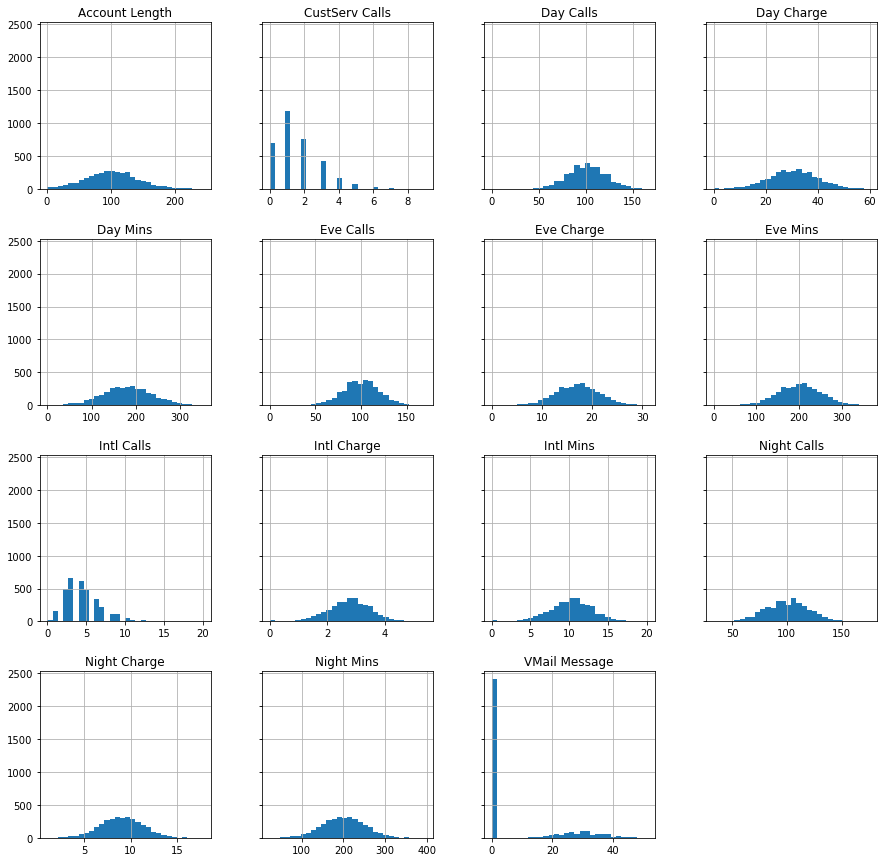

In [148]:
# Histograms for numeric features

display(tot.describe())
hist = tot.hist(bins=30, sharey=True, figsize=(15, 15))

We can immediately note that:

* State appears to be quite evenly distributed
* Since Phone takes on too many unique values to be of any practical use, we saved only the last digit for each customer to check if the data is unbiased. Because the 10 possible digits are evenly distributed (9% or 10% of total values each) we can conclude that our sample is random.
* Only 14% of customers churned, so there is some class imbalance, but nothing extreme.
* Most of the numeric features are surprisingly well distributed, with many showing bell-like normal characteristics.  VMail Message is a notable exception.

What we want to check next is how our dependent variable, Churn, is influenced by the predictors (the categorical and numeric variables in the dataset). 

First let's have a look at the relationship between each of the features and our target variable. Since the two variables have 2 classes, we can refer to this as a visual A/B Test:

<img src="intplan.png" width="350" height="300">
It clearly seems that customers with an international plan are more likely to leave than the ones that do not have one.

<img src="vmplan.png" width="350" height="300">
In this case, it is interesting for the company to look into why customers without a voice mail plan are more likely to leave than the ones that have one.

While visualisations help us establish possible connections between churning and the 2 variables, we still have to prove that these observed differences are statistically relevant. This can be done using a Chi-Square Test.

In [149]:
#Chi-Square test for International Plan

intplan = pd.crosstab(index=tot['Intl Plan'], columns=tot['Churn'])
obs1 = np.array(intplan)
obs1 = np.flip(obs1, 1)
obs1[:, 1] =  np.sum(obs1, 1)
chi2, p, dof, expected = stats.chi2_contingency(obs1)
print("Chi-Square Test Statistics for International Plan")
print("Degrees of freedom =", dof)
crit = stats.chi2.ppf(q = 0.95, df = dof)  # Find the critical value for 95% confidence
print("Critical value =%5.2f" % crit)
print("Chi-Square statistic =%7.2f" % chi2)
print("Associated p-value: %8.6f" % p)
print()

#Chi-Square test for Voice Mail Plan

vmplan = pd.crosstab(index=tot['VMail Plan'], columns=tot['Churn'])
obs2 = np.array(vmplan)
obs2 = np.flip(obs2, 1)
obs2[:, 1] =  np.sum(obs2, 1)
chi2, p, dof, expected = stats.chi2_contingency(obs2)
print("Chi-Square Test Statistics for Voice Mail Plan")
print("Degrees of freedom =", dof)
crit = stats.chi2.ppf(q = 0.95, df = dof)  # Find the critical value for 95% confidence
print("Critical value =%5.2f" % crit)
print("Chi-Square statistic =%6.2f" % chi2)
print("Associated p-value: %8.6f" % p)

Chi-Square Test Statistics for International Plan
Degrees of freedom = 1
Critical value = 3.84
Chi-Square statistic = 137.00
Associated p-value: 0.000000

Chi-Square Test Statistics for Voice Mail Plan
Degrees of freedom = 1
Critical value = 3.84
Chi-Square statistic = 26.27
Associated p-value: 0.000000


Since both **p-values** are way lower than 5% (even 1% or 0.1%), we can safely conclude that both plans are relevant for our prediction of churning customers. Therefore, these will be included in the xGboost model.

Further on, let's analyse the relationship between each of the numeric variables and our dependent variable. In order to be able to visualize it, the numeric variables have been placed in bins according to their span. This way, we can view them as histograms.

First we have the Account length:
<img src="AccLengthABT.png" width="640" height="400">

We can see that the reference line placed at 14% (the churn rate for the global population) indicates some groups are more likely to churn while others are less likely to do it.

Next variable is Customer service calls:
<img src="CustServCallsABT.png" width="640" height="400">

As intuitively expected, having more customer service calls could mean having problems with the service provided, therefore a higher churn rate.

The Voice Mail Messages:
<img src="VMMessABT.png" width="640" height="400">

We can see that a large number of customers have no Voice Mails at all. We will take this into consideration when testing variable importance in our predictive model.

For Day calls:
<img src="DayCallsABT.png" width="640" height="400">

We can see that the reference line placed at 14% indicates some groups are more likely to churn while others are less likely to do it.

For Day minutes and charges:
<img src="DayComp.png" width="800" height="640">

I plotted the variables next to each other for easier comparison. We can notice that their distributions are very similar, which raises the question of possible correlation between the 2.

For Evening calls:
<img src="EveCallsABT.png" width="640" height="400">

We can see that the reference line placed at 14% indicates some groups are more likely to churn while others are less likely to do it.

For Evening minutes and charges:
<img src="EveComp.png" width="800" height="640">

I plotted the variables next to each other for easier comparison. We can notice that their distributions are very similar, which raises the question of possible correlation between the 2.

For Night calls:
<img src="NightCallsABT.png" width="640" height="400">

We can see that the reference line placed at 14% indicates some groups are more likely to churn while others are less likely to do it.

For Night minutes and charges:
<img src="NightComp.png" width="800" height="640">

I plotted the variables next to each other for easier comparison. We can notice that their distributions are very similar, which raises the question of possible correlation between the 2.

For International calls:
<img src="IntlCallsABT.png" width="640" height="400">

We can see that the reference line placed at 14% indicates some groups are more likely to churn while others are less likely to do it.

For International minutes and charges:
<img src="IntlComp.png" width="800" height="640">

I plotted the variables next to each other for easier comparison. We can notice that their distributions are very similar, which raises the question of possible correlation between the 2.

Since there are 4 possible conflicts due to correlation, we will next build the correlation matrix for our variables.

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.00,-0.00,0.01,0.04,0.01,-0.01,0.02,-0.01,-0.01,-0.01,-0.01,0.01,0.02,0.01,-0.00
VMail Message,-0.00,1.00,0.00,-0.01,0.00,0.02,-0.01,0.02,0.01,0.01,0.01,0.00,0.01,0.00,-0.01
Day Mins,0.01,0.00,1.00,0.01,1.00,0.01,0.02,0.01,0.00,0.02,0.00,-0.01,0.01,-0.01,-0.01
Day Calls,0.04,-0.01,0.01,1.00,0.01,-0.02,0.01,-0.02,0.02,-0.02,0.02,0.02,0.00,0.02,-0.02
Day Charge,0.01,0.00,1.00,0.01,1.00,0.01,0.02,0.01,0.00,0.02,0.00,-0.01,0.01,-0.01,-0.01
Eve Mins,-0.01,0.02,0.01,-0.02,0.01,1.00,-0.01,1.00,-0.01,0.01,-0.01,-0.01,0.00,-0.01,-0.01
Eve Calls,0.02,-0.01,0.02,0.01,0.02,-0.01,1.00,-0.01,-0.00,0.01,-0.00,0.01,0.02,0.01,0.00
Eve Charge,-0.01,0.02,0.01,-0.02,0.01,1.00,-0.01,1.00,-0.01,0.01,-0.01,-0.01,0.00,-0.01,-0.01
Night Mins,-0.01,0.01,0.00,0.02,0.00,-0.01,-0.00,-0.01,1.00,0.01,1.00,-0.02,-0.01,-0.02,-0.01
Night Calls,-0.01,0.01,0.02,-0.02,0.02,0.01,0.01,0.01,0.01,1.00,0.01,-0.01,0.00,-0.01,-0.01


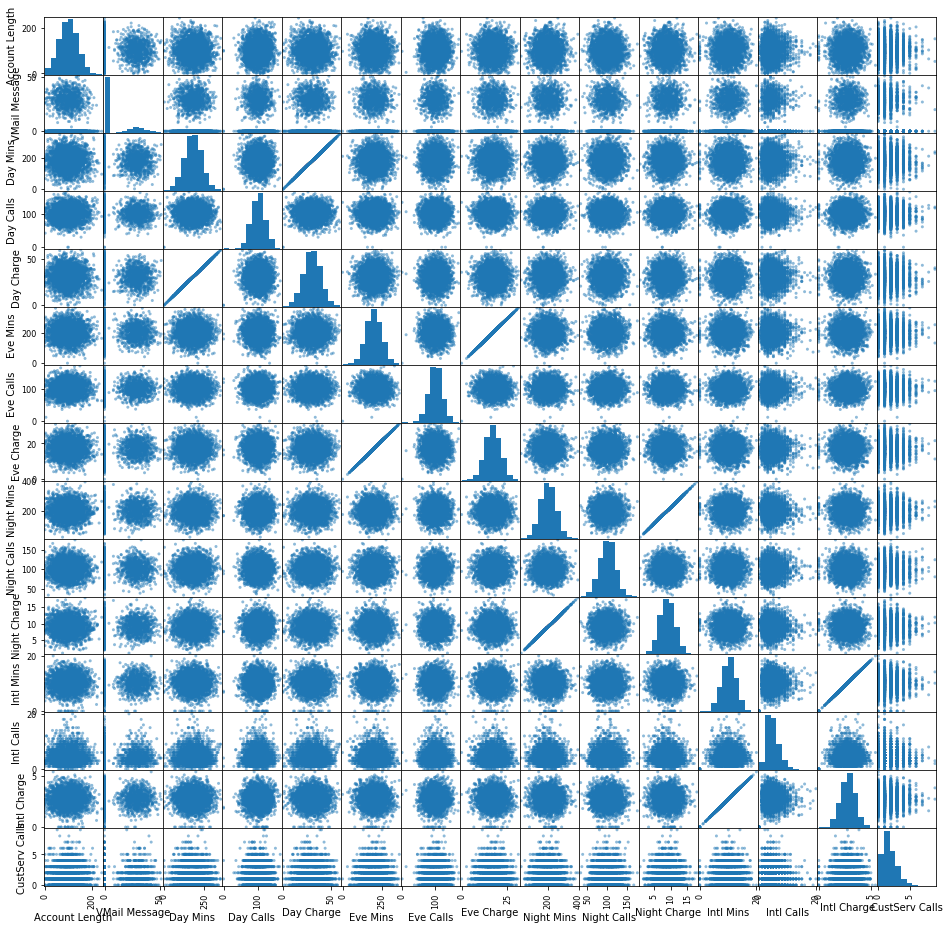

In [88]:
#Testing for variable correlations: correlation matrix and scatter plot

display(tot.corr())
pd.plotting.scatter_matrix(tot, figsize=(16, 16))
plt.show()

## Data preparation
As we anticipated earlier, we have 8 perfect correlation scores of 1.00 in the above matrix and 8 corresponding straight lines in our scatter plot. Therefore, we have to remove either the Charges or the Minutes variables from our model.

Since they are perfectly correlated, the model will perform the same if we drop either one of them. Looking at their distributions, I chose to drop the Charges variables for being more compact in value.

In [150]:
#Removing Charge variables for being perfectly correlated with Minute variables + Last phone digit

total = tot.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge', 'Phone'], axis=1)
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 16 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null object
Intl Plan         3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
CustServ Calls    3333 non-null int64
Churn             3333 non-null object
dtypes: float64(4), int64(7), object(5)
memory usage: 416.7+ KB


The extreme gradient boosting algorithm requires numeric variables only in order to train and then make predictions. The best approach for dealing with our object type variables is to transform them into dummies.

In [151]:
#Encoding the dependent variable Y

class_mapping = {label:idx for idx,label in enumerate(np.unique(tot['Churn']))}
total['Churn'] = tot['Churn'].map(class_mapping)
total['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [152]:
#Creating dummies for non-numerical variables using function pd.get_dummies()

Y = total['Churn']
X = total.drop(['Churn'], 1)
X = pd.get_dummies(X)
summary = X.describe()
print(summary)

       Account Length  VMail Message  Day Mins  Day Calls  Eve Mins  \
count         3333.00        3333.00   3333.00    3333.00   3333.00   
mean           101.06           8.10    179.78     100.44    200.98   
std             39.82          13.69     54.47      20.07     50.71   
min              1.00           0.00      0.00       0.00      0.00   
25%             74.00           0.00    143.70      87.00    166.60   
50%            101.00           0.00    179.40     101.00    201.40   
75%            127.00          20.00    216.40     114.00    235.30   
max            243.00          51.00    350.80     165.00    363.70   

       Eve Calls  Night Mins  Night Calls  Intl Mins  Intl Calls  \
count    3333.00     3333.00      3333.00    3333.00     3333.00   
mean      100.11      200.87       100.11      10.24        4.48   
std        19.92       50.57        19.57       2.79        2.46   
min         0.00       23.20        33.00       0.00        0.00   
25%        87.00    

## Predictive modelling
Now that our data is clean and ready for xGboost, we will perform a 30-70% split into test and training sets.

In [208]:
#Partition the dataset into training and validation

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

We will train the model on the 70% random sample we have just obtained:

In [209]:
#Fit model to training data

model = XGBClassifier()
model.fit(X_train, Y_train)
print(model)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


Next we will use the model to predict churning on our 30% validation random sample:

In [210]:
#Predictions on validation data set

Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.10%


Our model successfully predicted 95.1% of the customer churn in our validation set. We can compare the predicted results to the actual results in the confusion matrix: 

In [211]:
#Confusion matrix TN FP / FN TP

m_confusion = confusion_matrix(Y_test, Y_pred)
m_confusion

array([[846,  16],
       [ 33, 105]])

In the confusion matrix, the main diagonal represents the correctly predicted results: 846 correctly predicted non-churners and 105 correctly predicted churners. What is problematic for the company is the other diagonal, 16 falsely predicted non-churners and 33 falsely predicted churners. In this case, 16 people have actually not dropped the service and, more importantly, 33 have been predicted to stay when they actually left.

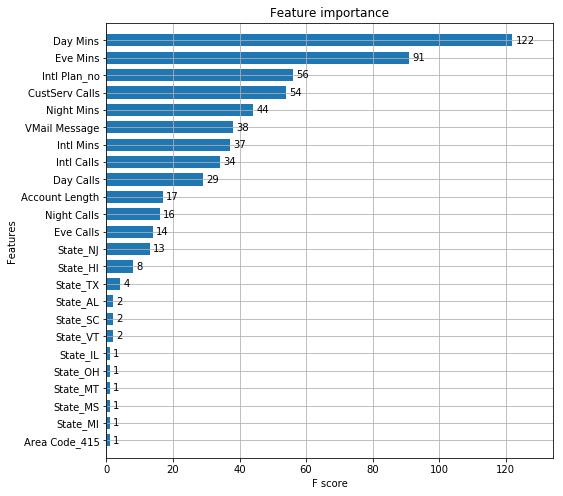

In [188]:
#Plotting variable importance

fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(model, ax=ax, height=0.7)
plt.show()

Based on the above plot, we notice that the first 9 components have a higher importance in predicting the result. That makes us wonder if the algorithm can be as accurate while simplified by dropping some predictors. In order to check this out, we can fiddle with the threshold and see what happens:

In [166]:
# Fit model using each importance as a threshold

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    Y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0)) 

Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
Thresh=0.000, n=69, Accuracy: 95.10%
T

Even better than expected, we notice that when we keep 9 components the model accuracy actually increases by 0.4% to 95.5%. Therefore, it is definitely advisable to **rebuild the model** with the 9 principal components as it will reduce computation time and slightly increase the overall accuracy.

In [172]:
#Rebuild model to increase accuracy to 95.50%

Yf = total['Churn']
Xf = total.drop(['Churn','State','Area Code','Account Length','Eve Calls','Night Calls'], 1)
Xf = pd.get_dummies(Xf)

Xf_train, Xf_test, Yf_train, Yf_test = train_test_split(Xf, Yf, test_size=0.3, random_state=0)

modelf = XGBClassifier()
modelf.fit(Xf_train, Yf_train)

Yf_pred = modelf.predict(Xf_test)
accuracyf = accuracy_score(Yf_test, Yf_pred)
print("Accuracy: %.2f%%" % (accuracyf * 100.0))

Accuracy: 95.50%


In [173]:
#Confusion matrix TN FP / FN TP

m_confusion_f = confusion_matrix(Yf_test, Yf_pred)
m_confusion_f

array([[849,  13],
       [ 32, 106]])

## Cost of errors
With the better model in place, we can address the problem of incorrect predictions. From a business point of view, the numbers obtained in the confusion matrix translate to operational costs, which we want to minimize. Therefore, we will now look into the relative cost of errors.

### Assigning values for the costs
What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of 0 units. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a new customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, let's assume it to be 500 units. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of 100 units. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will waste the 100 units concession. We probably could have spent that 100 units more effectively, but it is possible also that we increased the loyalty of an already loyal customer, so that’s not so bad.

In [227]:
def cost(x):
    return 500 * x[1,0] + 100 * x[0,1] + 100 * x[1,1]

print("Cost of error for initial model is", cost(m_confusion), 'units')
print("Cost of error for better model is", cost(m_confusion_f), 'units')


Cost of error for initial model is 28600 units
Cost of error for better model is 27900 units


In [243]:
# Test cost of error for different base scores in xgboost

cutoff = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
for i in range(0, 7):
    Yt = total['Churn']
    Xt = total.drop(['Churn','State','Area Code','Account Length','Eve Calls','Night Calls'], 1)
    Xt = pd.get_dummies(Xt)
    Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(Xt, Yt, test_size=0.3, random_state=0)
    modelt = XGBClassifier(base_score = cutoff[i])
    modelt.fit(Xt_train, Yt_train)
    Yt_pred = modelt.predict(Xt_test)
    mconf = confusion_matrix(Yt_test, Yt_pred)
    accuracyt = accuracy_score(Yt_test, Yt_pred)
    print("Base score = %.1f" % (cutoff[i]))
    print("xGboost Accuracy: %.2f%%" % (accuracyt * 100))
    print(mconf)
    print("Cost of error: %d" % (cost(mconf)))
    print()

Base score = 0.2
xGboost Accuracy: 95.70%
[[851  11]
 [ 32 106]]
Cost of error: 27700

Base score = 0.3
xGboost Accuracy: 95.40%
[[849  13]
 [ 33 105]]
Cost of error: 28300

Base score = 0.4
xGboost Accuracy: 95.50%
[[848  14]
 [ 31 107]]
Cost of error: 27600

Base score = 0.5
xGboost Accuracy: 95.50%
[[849  13]
 [ 32 106]]
Cost of error: 27900

Base score = 0.6
xGboost Accuracy: 95.70%
[[850  12]
 [ 31 107]]
Cost of error: 27400

Base score = 0.7
xGboost Accuracy: 95.60%
[[847  15]
 [ 29 109]]
Cost of error: 26900

Base score = 0.8
xGboost Accuracy: 95.30%
[[848  14]
 [ 33 105]]
Cost of error: 28400



Cost is minimised for the parameter base_score = 0.7

In [240]:
# Test cost of error for different depths in xgboost

dep = np.array([3, 5, 7, 9, 11, 13, 15])
for i in range(0, 7):
    Yt = total['Churn']
    Xt = total.drop(['Churn','State','Area Code','Account Length','Eve Calls','Night Calls'], 1)
    Xt = pd.get_dummies(Xt)
    Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(Xt, Yt, test_size=0.3, random_state=0)
    modelt = XGBClassifier(max_depth = dep[i])
    modelt.fit(Xt_train, Yt_train)
    Yt_pred = modelt.predict(Xt_test)
    mconf = confusion_matrix(Yt_test, Yt_pred)
    accuracyt = accuracy_score(Yt_test, Yt_pred)
    print("Maximum depth = %d" % (dep[i]))
    print("xGboost Accuracy: %.2f%%" % (accuracyt * 100))
    print(mconf)
    print("Cost of error: %d" % (cost(mconf)))
    print()

Maximum depth = 3
xGboost Accuracy: 95.50%
[[849  13]
 [ 32 106]]
Cost of error: 27900

Maximum depth = 5
xGboost Accuracy: 95.80%
[[849  13]
 [ 29 109]]
Cost of error: 26700

Maximum depth = 7
xGboost Accuracy: 95.90%
[[850  12]
 [ 29 109]]
Cost of error: 26600

Maximum depth = 9
xGboost Accuracy: 95.80%
[[848  14]
 [ 28 110]]
Cost of error: 26400

Maximum depth = 11
xGboost Accuracy: 95.90%
[[850  12]
 [ 29 109]]
Cost of error: 26600

Maximum depth = 13
xGboost Accuracy: 95.60%
[[846  16]
 [ 28 110]]
Cost of error: 26600

Maximum depth = 15
xGboost Accuracy: 95.80%
[[848  14]
 [ 28 110]]
Cost of error: 26400



Cost is minimised for the parameter max_depth = 9

In [241]:
# Test cost of error for different learning rates in xgboost

learn = np.array([0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2])
for i in range(0, 7):
    Yt = total['Churn']
    Xt = total.drop(['Churn','State','Area Code','Account Length','Eve Calls','Night Calls'], 1)
    Xt = pd.get_dummies(Xt)
    Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(Xt, Yt, test_size=0.3, random_state=0)
    modelt = XGBClassifier(learning_rate = learn[i])
    modelt.fit(Xt_train, Yt_train)
    Yt_pred = modelt.predict(Xt_test)
    mconf = confusion_matrix(Yt_test, Yt_pred)
    accuracyt = accuracy_score(Yt_test, Yt_pred)
    print("Learning = %.3f" % (learn[i]))
    print("xGboost Accuracy: %.2f%%" % (accuracyt * 100))
    print(mconf)
    print("Cost of error: %d" % (cost(mconf)))
    print()

Learning = 0.010
xGboost Accuracy: 91.60%
[[847  15]
 [ 69  69]]
Cost of error: 42900

Learning = 0.050
xGboost Accuracy: 95.00%
[[853   9]
 [ 41  97]]
Cost of error: 31100

Learning = 0.075
xGboost Accuracy: 95.20%
[[850  12]
 [ 36 102]]
Cost of error: 29400

Learning = 0.100
xGboost Accuracy: 95.50%
[[849  13]
 [ 32 106]]
Cost of error: 27900

Learning = 0.125
xGboost Accuracy: 95.90%
[[852  10]
 [ 31 107]]
Cost of error: 27200

Learning = 0.150
xGboost Accuracy: 95.90%
[[852  10]
 [ 31 107]]
Cost of error: 27200

Learning = 0.200
xGboost Accuracy: 95.60%
[[850  12]
 [ 32 106]]
Cost of error: 27800



Cost is minimised for the parameter learning_rate = 0.15

Putting it all together:

In [244]:
Yt = total['Churn']
Xt = total.drop(['Churn','State','Area Code','Account Length','Eve Calls','Night Calls'], 1)
Xt = pd.get_dummies(Xt)
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(Xt, Yt, test_size=0.3, random_state=0)
modelt = XGBClassifier(max_depth = 9, learning_rate = 0.15, base_score = 0.7)
modelt.fit(Xt_train, Yt_train)
Yt_pred = modelt.predict(Xt_test)
mconf = confusion_matrix(Yt_test, Yt_pred)
accuracyt = accuracy_score(Yt_test, Yt_pred)

print("xGboost Accuracy: %.2f%%" % (accuracyt * 100))
print(mconf)
print("Cost of error: %d" % (cost(mconf)))
print()

xGboost Accuracy: 96.20%
[[851  11]
 [ 27 111]]
Cost of error: 25700



Victory, we have reduced the cost to **25700 units** (from 28600 and 27900 previously) on a 30-70 split of the dataset. Hope you have enjoyed this notebook!